# EdgeFace: MTCNN vs YuNet Face Detection & Alignment Comparison

Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏóêÏÑúÎäî EdgeFace-XS(Œ≥=0.6) Î™®Îç∏ ÌèâÍ∞ÄÎ•º ÏúÑÌï¥ MTCNNÍ≥º YuNet Í∏∞Î∞ò face detection Î∞è alignmentÏùò ÏÑ±Îä•Í≥º ÏÜçÎèÑÎ•º ÎπÑÍµêÌï©ÎãàÎã§.

## Î™©Ìëú
1. MTCNN(CPU) vs YuNet(CPU) Ï∂îÎ°† ÏÜçÎèÑ ÎπÑÍµê
2. Face alignment Í≤∞Í≥º ÏãúÍ∞ÅÏ†Å ÎπÑÍµê
3. EdgeFace Î™®Îç∏ ÏÑ±Îä•Ïóê ÎØ∏ÏπòÎäî ÏòÅÌñ• Î∂ÑÏÑù
4. Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÎπÑÍµê

In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from PIL import Image
from torchvision import transforms
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ÏãúÏä§ÌÖúÏóê ÏÑ§ÏπòÎêú ÌïúÍ∏Ä Ìè∞Ìä∏ ÌôïÏù∏ Î∞è ÏÑ§Ï†ï
import matplotlib.font_manager as fm

# ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÌïúÍ∏Ä Ìè∞Ìä∏ Ï∞æÍ∏∞
available_fonts = [f.name for f in fm.fontManager.ttflist]
korean_fonts = ['NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 'AppleGothic', 'D2Coding']

selected_font = None
for font in korean_fonts:
    if font in available_fonts:
        selected_font = font
        break

if selected_font:
    plt.rcParams['font.family'] = selected_font
    print(f"ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï: {selected_font}")
else:
    # Ìè∞Ìä∏Í∞Ä ÏóÜÏùÑ Í≤ΩÏö∞ Ïú†ÎãàÏΩîÎìú ÏßÄÏõê Ìè∞Ìä∏ ÏÇ¨Ïö©
    try:
        # LinuxÏùò Í≤ΩÏö∞ Noto Sans CJK ÏãúÎèÑ
        if os.path.exists('/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc'):
            plt.rcParams['font.family'] = 'Noto Sans CJK KR'
        elif os.path.exists('/System/Library/Fonts/AppleSDGothicNeo.ttc'):  # macOS
            plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
        else:
            # Í∏∞Î≥∏ ÏÑ§Ï†ïÏúºÎ°ú fallback
            plt.rcParams['font.family'] = 'sans-serif'
        print("Í∏∞Î≥∏ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ÏôÑÎ£å")
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï Ïã§Ìå® - Í∏∞Î≥∏ Ìè∞Ìä∏ ÏÇ¨Ïö©")

# EdgeFace Í¥ÄÎ†® import
from backbones import get_model
from face_alignment.align_cpu import get_aligned_face_cpu
from face_alignment.yunet import YuNetDetector, get_aligned_face_yunet

print("ÎùºÏù¥Î∏åÎü¨Î¶¨ Î°úÎî© ÏôÑÎ£å")

ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï: NanumGothic
ÎùºÏù¥Î∏åÎü¨Î¶¨ Î°úÎî© ÏôÑÎ£å


## 1. Î™®Îç∏ Î∞è ÏÑ§Ï†ï Ï¥àÍ∏∞Ìôî

In [2]:
# EdgeFace Î™®Îç∏ Î°úÎìú
arch = "edgeface_xs_gamma_06"
model = get_model(arch)
checkpoint_path = f'checkpoints/{arch}.pt'

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"EdgeFace Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: {arch}")
else:
    print(f"Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§: {checkpoint_path}")
    print("ÌóàÎ∏åÏóêÏÑú Î™®Îç∏ÏùÑ Î°úÎìúÌï©ÎãàÎã§...")
    model = torch.hub.load('otroshi/edgeface', arch, source='github', pretrained=True)

model.eval()

# Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Î≥ÄÌôò
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

print("EdgeFace Î™®Îç∏ Ï§ÄÎπÑ ÏôÑÎ£å")

EdgeFace Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: edgeface_xs_gamma_06
EdgeFace Î™®Îç∏ Ï§ÄÎπÑ ÏôÑÎ£å


In [3]:
# YuNet Î™®Îç∏ Í≤ΩÎ°ú ÏÑ§Ï†ï
yunet_model_path = "libfacedetection/opencv_zoo/models/face_detection_yunet/face_detection_yunet_2023mar.onnx"

if not os.path.exists(yunet_model_path):
    print(f"YuNet Î™®Îç∏ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§: {yunet_model_path}")
    print("ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨Ïùò YuNet Î™®Îç∏ÏùÑ Ï∞æÎäî Ï§ë...")
    import glob
    yunet_files = glob.glob("**/face_detection_yunet_2023mar.onnx", recursive=True)
    if yunet_files:
        yunet_model_path = yunet_files[0]
        print(f"YuNet Î™®Îç∏ Î∞úÍ≤¨: {yunet_model_path}")
    else:
        print("YuNet Î™®Îç∏ÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
else:
    print(f"YuNet Î™®Îç∏ Í≤ΩÎ°ú ÌôïÏù∏: {yunet_model_path}")

# YuNet Í≤ÄÏ∂úÍ∏∞ Ï¥àÍ∏∞Ìôî
yunet_detector = None
try:
    if os.path.exists(yunet_model_path):
        yunet_detector = YuNetDetector(yunet_model_path, device='cpu', crop_size=(112, 112))
        print("YuNet Í≤ÄÏ∂úÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    else:
        print("YuNet Î™®Îç∏ ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§.")
except Exception as e:
    print(f"YuNet Ï¥àÍ∏∞Ìôî Ïò§Î•ò: {e}")
    print("YuNet Í∏∞Îä•Ïù¥ ÎπÑÌôúÏÑ±ÌôîÎê©ÎãàÎã§.")
    
# YuNet ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏
yunet_available = yunet_detector is not None
print(f"YuNet ÏÇ¨Ïö© Í∞ÄÎä•: {yunet_available}")

YuNet Î™®Îç∏ Í≤ΩÎ°ú ÌôïÏù∏: libfacedetection/opencv_zoo/models/face_detection_yunet/face_detection_yunet_2023mar.onnx
YuNet Í≤ÄÏ∂úÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
YuNet ÏÇ¨Ïö© Í∞ÄÎä•: True


## 2. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ï§ÄÎπÑ

In [4]:
# ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú ÏÑ§Ï†ï
test_images = []

# 1. Í∏∞Ï°¥ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÎîîÎ†âÌÜ†Î¶¨Ïùò ÏÉòÌîå Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
# if os.path.exists('checkpoints/synthface.jpeg'):
#     test_images.append('checkpoints/synthface.jpeg')

# 2. libfacedetectionÏùò ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÎì§ ÌôïÏù∏
sample_dir = "face_alignment/test_images"
if os.path.exists(sample_dir):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        import glob
        test_images.extend(glob.glob(f"{sample_dir}/{ext}"))

# 3. opencv_zooÏùò ÏÉòÌîå Ïù¥ÎØ∏ÏßÄÎì§ ÌôïÏù∏ (gif Ï†úÏô∏)
opencv_sample_dir = "libfacedetection/opencv_zoo/models/face_detection_yunet/example_outputs"
if os.path.exists(opencv_sample_dir):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        import glob
        test_images.extend(glob.glob(f"{opencv_sample_dir}/{ext}"))

# Ïú†Ìö®Ìïú Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎßå ÌïÑÌÑ∞ÎßÅ
valid_test_images = []
print(f"Î∞úÍ≤¨Îêú ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ: {len(test_images)}Í∞ú")

for img_path in test_images:
    try:
        # Ïù¥ÎØ∏ÏßÄ Î°úÎìú ÌÖåÏä§Ìä∏
        with Image.open(img_path) as img:
            img.verify()  # Ïù¥ÎØ∏ÏßÄ Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨
        valid_test_images.append(img_path)
        print(f"  ‚úÖ {os.path.basename(img_path)}")
    except Exception as e:
        print(f"  ‚ùå {os.path.basename(img_path)} - ÏÜêÏÉÅÎêú ÌååÏùº: {e}")

test_images = valid_test_images

if len(test_images) == 0:
    print("\nÏú†Ìö®Ìïú ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. Í∏∞Î≥∏ Ïù¥ÎØ∏ÏßÄÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§...")
    # Í∏∞Î≥∏ ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (Îã®ÏÉâ Ïù¥ÎØ∏ÏßÄ)
    default_img = Image.new('RGB', (224, 224), color='white')
    default_img.save('test_sample.jpg')
    test_images = ['test_sample.jpg']
    print("Í∏∞Î≥∏ ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± ÏôÑÎ£å")

print(f"\nÏµúÏ¢Ö Ïú†Ìö® ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ: {len(test_images)}Í∞ú")

Î∞úÍ≤¨Îêú ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ: 4Í∞ú
  ‚úÖ img2.jpeg
  ‚úÖ img3.jpeg
  ‚úÖ img1.jpeg
  ‚ùå largest_selfie.jpg - ÏÜêÏÉÅÎêú ÌååÏùº: cannot identify image file 'libfacedetection/opencv_zoo/models/face_detection_yunet/example_outputs/largest_selfie.jpg'

ÏµúÏ¢Ö Ïú†Ìö® ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ: 3Í∞ú


## 3. ÏÜçÎèÑ Î≤§ÏπòÎßàÌÅ¨ Ìï®Ïàò Ï†ïÏùò

In [5]:
def measure_inference_time(detector_func, image_path, num_runs=10):
    """
    Í≤ÄÏ∂úÍ∏∞Ïùò Ï∂îÎ°† ÏãúÍ∞ÑÏùÑ Ï∏°Ï†ïÌï©ÎãàÎã§.
    
    Args:
        detector_func: Í≤ÄÏ∂ú Ìï®Ïàò
        image_path: Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú
        num_runs: Î∞òÎ≥µ Ïã§Ìñâ ÌöüÏàò
    
    Returns:
        (avg_time, std_time, success_rate): ÌèâÍ∑† ÏãúÍ∞Ñ, ÌëúÏ§ÄÌé∏Ï∞®, ÏÑ±Í≥µÎ•†
    """
    times = []
    successes = 0
    
    # ÏõåÎ∞çÏóÖ
    try:
        detector_func(image_path)
    except:
        pass
    
    for _ in range(num_runs):
        try:
            start_time = time.time()
            result = detector_func(image_path)
            end_time = time.time()
            
            if result is not None:
                times.append(end_time - start_time)
                successes += 1
        except Exception as e:
            print(f"Ïò§Î•ò Î∞úÏÉù: {e}")
            continue
    
    if len(times) > 0:
        avg_time = np.mean(times) * 1000  # msÎ°ú Î≥ÄÌôò
        std_time = np.std(times) * 1000
        success_rate = successes / num_runs
    else:
        avg_time, std_time, success_rate = 0, 0, 0
    
    return avg_time, std_time, success_rate

def measure_memory_usage():
    """
    ÌòÑÏû¨ ÌîÑÎ°úÏÑ∏Ïä§Ïùò Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏùÑ Ï∏°Ï†ïÌï©ÎãàÎã§.
    """
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / 1024 / 1024  # MBÎ°ú Î≥ÄÌôò

print("Î≤§ÏπòÎßàÌÅ¨ Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

Î≤§ÏπòÎßàÌÅ¨ Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


## 4. EdgeFace Ï∂îÎ°† Ìï®Ïàò Ï†ïÏùò

In [6]:
def get_edgeface_embedding(aligned_face):
    """
    Aligned faceÎ°úÎ∂ÄÌÑ∞ EdgeFace embeddingÏùÑ Ï∂îÏ∂úÌï©ÎãàÎã§.
    
    Args:
        aligned_face: PIL Image (112x112)
    
    Returns:
        embedding: torch.Tensor
    """
    if aligned_face is None:
        return None
    
    try:
        # Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨
        input_tensor = transform(aligned_face).unsqueeze(0)
        
        # EdgeFace Ï∂îÎ°†
        with torch.no_grad():
            embedding = model(input_tensor)
        
        return embedding
    except Exception as e:
        print(f"EdgeFace Ï∂îÎ°† Ïò§Î•ò: {e}")
        return None

def mtcnn_pipeline(image_path):
    """
    MTCNNÏùÑ ÏÇ¨Ïö©Ìïú Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏ (Detection + Alignment + EdgeFace)
    """
    aligned_face = get_aligned_face_cpu(image_path)
    if aligned_face is None:
        return None
    embedding = get_edgeface_embedding(aligned_face)
    return embedding

def yunet_pipeline(image_path):
    """
    YuNetÏùÑ ÏÇ¨Ïö©Ìïú Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏ (Detection + Alignment + EdgeFace)
    """
    global yunet_detector, yunet_available
    if not yunet_available or yunet_detector is None:
        return None
        
    try:
        img = Image.open(image_path).convert('RGB')
        aligned_face = yunet_detector.align(img)
        if aligned_face is None:
            return None
        embedding = get_edgeface_embedding(aligned_face)
        return embedding
    except Exception as e:
        print(f"YuNet ÌååÏù¥ÌîÑÎùºÏù∏ Ïò§Î•ò: {e}")
        return None

def safe_yunet_align(image_path):
    """
    ÏïàÏ†ÑÌïú YuNet alignment Ìï®Ïàò (global Î≥ÄÏàò Î™ÖÏãúÏ†Å Ï∞∏Ï°∞)
    """
    global yunet_detector, yunet_available
    if not yunet_available or yunet_detector is None:
        return None
    try:
        img = Image.open(image_path).convert('RGB')
        return yunet_detector.align(img)
    except Exception as e:
        print(f"YuNet alignment Ïò§Î•ò: {e}")
        return None

# Ï†ÑÏó≠ Î≥ÄÏàò ÌôïÏù∏ Ìï®Ïàò
def check_yunet_status():
    """
    YuNet ÏÉÅÌÉúÎ•º ÌôïÏù∏ÌïòÎäî Ìï®Ïàò
    """
    global yunet_detector, yunet_available
    print(f"yunet_available: {yunet_available}")
    print(f"yunet_detector is None: {yunet_detector is None}")
    return yunet_available and yunet_detector is not None

print("EdgeFace Ï∂îÎ°† Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")
print(f"ÌòÑÏû¨ YuNet ÏÉÅÌÉú: {check_yunet_status()}")

EdgeFace Ï∂îÎ°† Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å
yunet_available: True
yunet_detector is None: False
ÌòÑÏû¨ YuNet ÏÉÅÌÉú: True


## 5. ÏÑ±Îä• Î≤§ÏπòÎßàÌÅ¨ Ïã§Ìñâ

In [7]:
# Ï†ÑÏó≠ Î≥ÄÏàò ÌôïÏù∏
global yunet_detector, yunet_available

# Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
benchmark_results = []

print("MTCNN vs YuNet ÏÑ±Îä• Î≤§ÏπòÎßàÌÅ¨ ÏãúÏûë...")
print(f"ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ïàò: {len(test_images[:3])}Í∞ú")  # Ï≤òÏùå 3Í∞ú Ïù¥ÎØ∏ÏßÄÎßå ÌÖåÏä§Ìä∏
print(f"YuNet ÏÇ¨Ïö© Í∞ÄÎä•: {yunet_available}")
print("="*60)

for i, image_path in enumerate(test_images[:3]):
    print(f"\nÏù¥ÎØ∏ÏßÄ {i+1}: {os.path.basename(image_path)}")
    
    try:
        # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ïÎ≥¥
        img = Image.open(image_path)
        img_size = img.size
        print(f"Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞: {img_size}")
        
        # MTCNN Î≤§ÏπòÎßàÌÅ¨
        print("MTCNN ÌÖåÏä§Ìä∏ Ï§ë...")
        mem_before_mtcnn = measure_memory_usage()
        mtcnn_time, mtcnn_std, mtcnn_success = measure_inference_time(
            get_aligned_face_cpu, image_path, num_runs=5
        )
        mem_after_mtcnn = measure_memory_usage()
        mtcnn_memory = mem_after_mtcnn - mem_before_mtcnn
        
        # YuNet Î≤§ÏπòÎßàÌÅ¨
        if yunet_available and yunet_detector is not None:
            print("YuNet ÌÖåÏä§Ìä∏ Ï§ë...")
            mem_before_yunet = measure_memory_usage()
            
            # ÏßÅÏ†ë lambda Ìï®ÏàòÎ°ú Ï†ïÏùòÌï¥ÏÑú Ï†ÑÏó≠ Î≥ÄÏàò ÏùòÏ°¥ÏÑ± Ï†úÍ±∞
            def yunet_align_wrapper(path):
                try:
                    img_temp = Image.open(path).convert('RGB')
                    return yunet_detector.align(img_temp)
                except Exception as e:
                    print(f"YuNet wrapper Ïò§Î•ò: {e}")
                    return None
            
            yunet_time, yunet_std, yunet_success = measure_inference_time(
                yunet_align_wrapper, image_path, num_runs=5
            )
            mem_after_yunet = measure_memory_usage()
            yunet_memory = mem_after_yunet - mem_before_yunet
        else:
            print("YuNetÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏäµÎãàÎã§ - Í±¥ÎÑàÎúÄ")
            yunet_time, yunet_std, yunet_success, yunet_memory = 0, 0, 0, 0
        
        # Í≤∞Í≥º Ï†ÄÏû•
        result = {
            'image': os.path.basename(image_path),
            'image_size': f"{img_size[0]}x{img_size[1]}",
            'mtcnn_time_ms': mtcnn_time,
            'mtcnn_std_ms': mtcnn_std,
            'mtcnn_success_rate': mtcnn_success,
            'mtcnn_memory_mb': mtcnn_memory,
            'yunet_time_ms': yunet_time,
            'yunet_std_ms': yunet_std,
            'yunet_success_rate': yunet_success,
            'yunet_memory_mb': yunet_memory,
            'speedup_ratio': mtcnn_time / yunet_time if yunet_time > 0 else 0
        }
        benchmark_results.append(result)
        
        # Ï§ëÍ∞Ñ Í≤∞Í≥º Ï∂úÎ†•
        print(f"  MTCNN: {mtcnn_time:.1f}¬±{mtcnn_std:.1f}ms (ÏÑ±Í≥µÎ•†: {mtcnn_success:.1%})")
        if yunet_available:
            print(f"  YuNet: {yunet_time:.1f}¬±{yunet_std:.1f}ms (ÏÑ±Í≥µÎ•†: {yunet_success:.1%})")
            print(f"  ÏÜçÎèÑ Ìñ•ÏÉÅ: {result['speedup_ratio']:.2f}x")
        else:
            print(f"  YuNet: ÏÇ¨Ïö© Î∂àÍ∞Ä")
        
    except Exception as e:
        print(f"Ïò§Î•ò Î∞úÏÉù: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\nÎ≤§ÏπòÎßàÌÅ¨ ÏôÑÎ£å!")

MTCNN vs YuNet ÏÑ±Îä• Î≤§ÏπòÎßàÌÅ¨ ÏãúÏûë...
ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ïàò: 3Í∞ú
YuNet ÏÇ¨Ïö© Í∞ÄÎä•: True

Ïù¥ÎØ∏ÏßÄ 1: img2.jpeg
Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞: (201, 251)
MTCNN ÌÖåÏä§Ìä∏ Ï§ë...
YuNet ÌÖåÏä§Ìä∏ Ï§ë...
  MTCNN: 13.5¬±3.0ms (ÏÑ±Í≥µÎ•†: 100.0%)
  YuNet: 2.8¬±0.4ms (ÏÑ±Í≥µÎ•†: 100.0%)
  ÏÜçÎèÑ Ìñ•ÏÉÅ: 4.81x

Ïù¥ÎØ∏ÏßÄ 2: img3.jpeg
Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞: (1168, 998)
MTCNN ÌÖåÏä§Ìä∏ Ï§ë...
YuNet ÌÖåÏä§Ìä∏ Ï§ë...
  MTCNN: 130.8¬±13.7ms (ÏÑ±Í≥µÎ•†: 100.0%)
  YuNet: 17.4¬±1.6ms (ÏÑ±Í≥µÎ•†: 100.0%)
  ÏÜçÎèÑ Ìñ•ÏÉÅ: 7.53x

Ïù¥ÎØ∏ÏßÄ 3: img1.jpeg
Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞: (259, 194)
MTCNN ÌÖåÏä§Ìä∏ Ï§ë...
YuNet ÌÖåÏä§Ìä∏ Ï§ë...
  MTCNN: 9.6¬±0.4ms (ÏÑ±Í≥µÎ•†: 100.0%)
  YuNet: 2.4¬±0.6ms (ÏÑ±Í≥µÎ•†: 100.0%)
  ÏÜçÎèÑ Ìñ•ÏÉÅ: 3.96x

Î≤§ÏπòÎßàÌÅ¨ ÏôÑÎ£å!


## 6. Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÏÑù

In [8]:
# Í≤∞Í≥ºÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
if benchmark_results:
    df_results = pd.DataFrame(benchmark_results)
    
    print("=== Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥º ÏöîÏïΩ ===")
    print(df_results.to_string(index=False))
    
    # ÌèâÍ∑† ÏÑ±Îä• Í≥ÑÏÇ∞
    avg_mtcnn_time = df_results['mtcnn_time_ms'].mean()
    avg_yunet_time = df_results['yunet_time_ms'].mean()
    avg_speedup = df_results['speedup_ratio'].mean()
    
    print(f"\n=== ÌèâÍ∑† ÏÑ±Îä• ===")
    print(f"MTCNN ÌèâÍ∑† Ï∂îÎ°† ÏãúÍ∞Ñ: {avg_mtcnn_time:.1f}ms")
    print(f"YuNet ÌèâÍ∑† Ï∂îÎ°† ÏãúÍ∞Ñ: {avg_yunet_time:.1f}ms")
    print(f"ÌèâÍ∑† ÏÜçÎèÑ Ìñ•ÏÉÅ: {avg_speedup:.2f}x")
    
else:
    print("Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§.")

=== Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥º ÏöîÏïΩ ===
    image image_size  mtcnn_time_ms  mtcnn_std_ms  mtcnn_success_rate  mtcnn_memory_mb  yunet_time_ms  yunet_std_ms  yunet_success_rate  yunet_memory_mb  speedup_ratio
img2.jpeg    201x251      13.450813      3.039857                 1.0        11.925781       2.794456      0.381929                 1.0        14.964844       4.813392
img3.jpeg   1168x998     130.786657     13.668913                 1.0        12.011719      17.359066      1.649924                 1.0       109.285156       7.534199
img1.jpeg    259x194       9.613466      0.352163                 1.0         0.257812       2.426577      0.641643                 1.0      -110.710938       3.961740

=== ÌèâÍ∑† ÏÑ±Îä• ===
MTCNN ÌèâÍ∑† Ï∂îÎ°† ÏãúÍ∞Ñ: 51.3ms
YuNet ÌèâÍ∑† Ï∂îÎ°† ÏãúÍ∞Ñ: 7.5ms
ÌèâÍ∑† ÏÜçÎèÑ Ìñ•ÏÉÅ: 5.44x


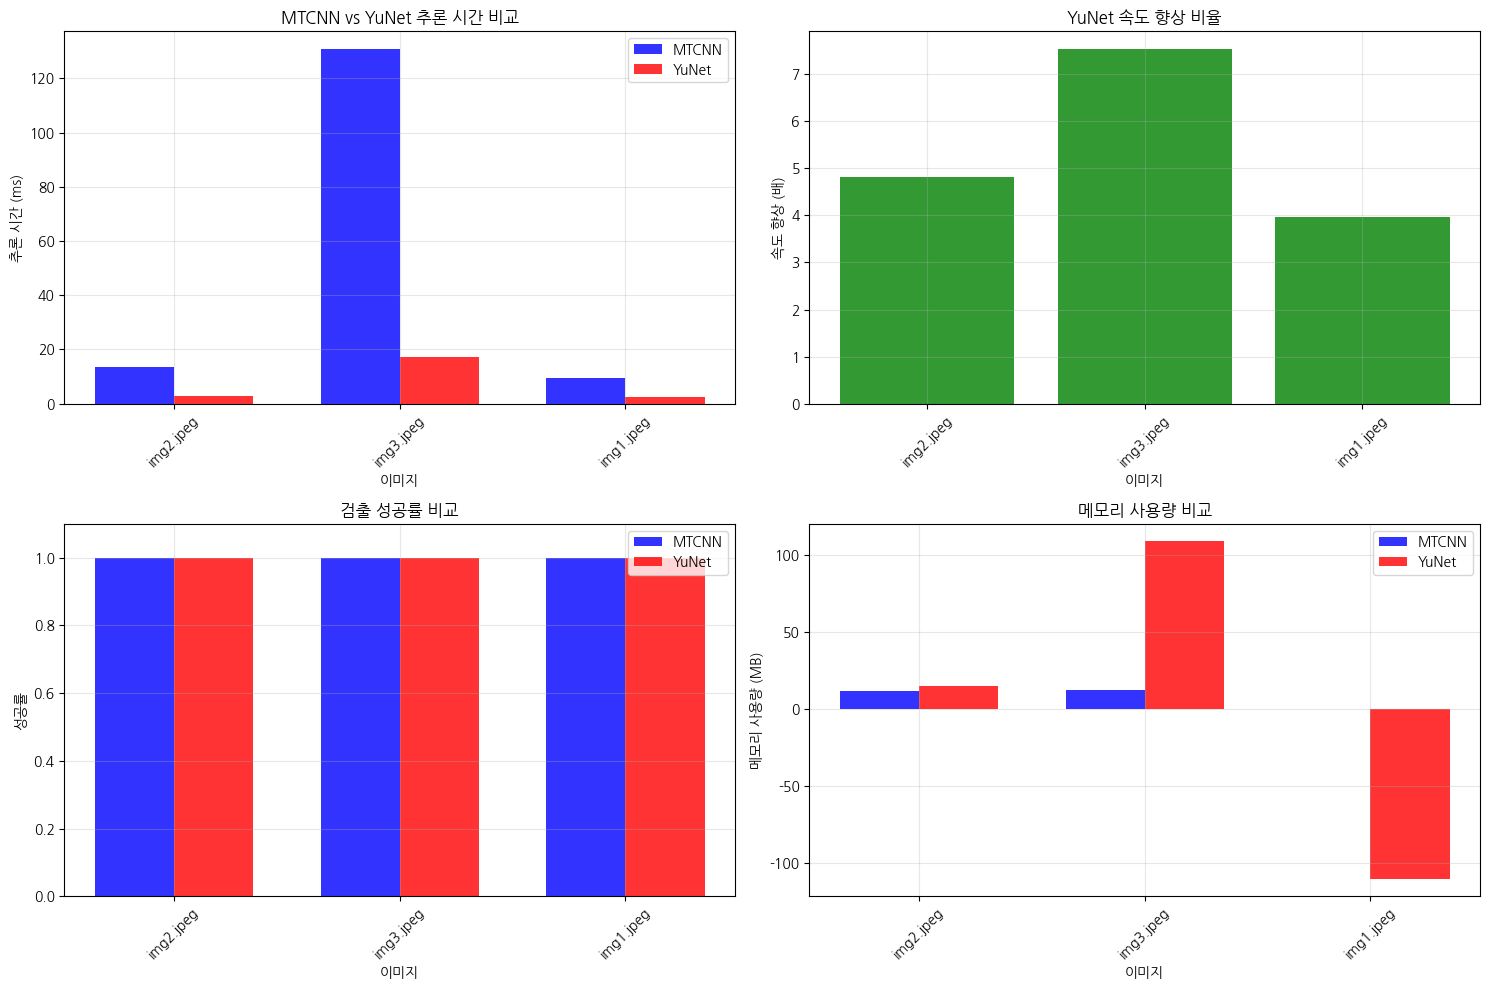

In [9]:
# ÏãúÍ∞ÅÌôî
if benchmark_results and len(benchmark_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Ï∂îÎ°† ÏãúÍ∞Ñ ÎπÑÍµê
    ax1 = axes[0, 0]
    x_pos = np.arange(len(df_results))
    width = 0.35
    
    ax1.bar(x_pos - width/2, df_results['mtcnn_time_ms'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax1.bar(x_pos + width/2, df_results['yunet_time_ms'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax1.set_xlabel('Ïù¥ÎØ∏ÏßÄ')
    ax1.set_ylabel('Ï∂îÎ°† ÏãúÍ∞Ñ (ms)')
    ax1.set_title('MTCNN vs YuNet Ï∂îÎ°† ÏãúÍ∞Ñ ÎπÑÍµê')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_results['image'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ÏÜçÎèÑ Ìñ•ÏÉÅ ÎπÑÏú®
    ax2 = axes[0, 1]
    ax2.bar(x_pos, df_results['speedup_ratio'], alpha=0.8, color='green')
    ax2.set_xlabel('Ïù¥ÎØ∏ÏßÄ')
    ax2.set_ylabel('ÏÜçÎèÑ Ìñ•ÏÉÅ (Î∞∞)')
    ax2.set_title('YuNet ÏÜçÎèÑ Ìñ•ÏÉÅ ÎπÑÏú®')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_results['image'], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. ÏÑ±Í≥µÎ•† ÎπÑÍµê
    ax3 = axes[1, 0]
    ax3.bar(x_pos - width/2, df_results['mtcnn_success_rate'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax3.bar(x_pos + width/2, df_results['yunet_success_rate'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax3.set_xlabel('Ïù¥ÎØ∏ÏßÄ')
    ax3.set_ylabel('ÏÑ±Í≥µÎ•†')
    ax3.set_title('Í≤ÄÏ∂ú ÏÑ±Í≥µÎ•† ÎπÑÍµê')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(df_results['image'], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.1)
    
    # 4. Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÎπÑÍµê
    ax4 = axes[1, 1]
    ax4.bar(x_pos - width/2, df_results['mtcnn_memory_mb'], width, 
            label='MTCNN', alpha=0.8, color='blue')
    ax4.bar(x_pos + width/2, df_results['yunet_memory_mb'], width, 
            label='YuNet', alpha=0.8, color='red')
    
    ax4.set_xlabel('Ïù¥ÎØ∏ÏßÄ')
    ax4.set_ylabel('Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ (MB)')
    ax4.set_title('Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÎπÑÍµê')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(df_results['image'], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("ÏãúÍ∞ÅÌôîÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")

## 7. Face Alignment Í≤∞Í≥º ÏãúÍ∞ÅÏ†Å ÎπÑÍµê

ÏãúÍ∞ÅÏ†Å ÎπÑÍµê ÎåÄÏÉÅ: img2.jpeg


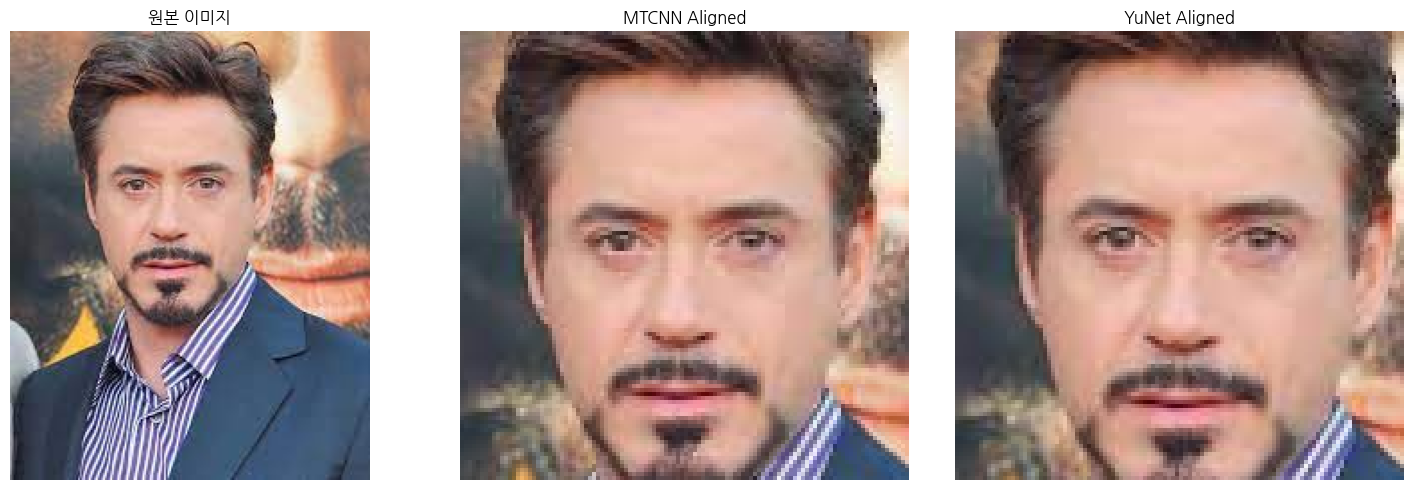


EdgeFace Embedding ÎπÑÍµê:
ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ: 0.9850
ÏûÑÎ≤†Îî© Ï∞®Ïù¥ (L2): 0.0549


In [10]:
# Ï≤´ Î≤àÏß∏ ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÎ°ú ÏãúÍ∞ÅÏ†Å ÎπÑÍµê
global yunet_detector, yunet_available

if test_images:
    test_image_path = test_images[0]
    print(f"ÏãúÍ∞ÅÏ†Å ÎπÑÍµê ÎåÄÏÉÅ: {os.path.basename(test_image_path)}")
    
    try:
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Î°úÎìú
        original_img = Image.open(test_image_path).convert('RGB')
        
        # MTCNN alignment
        mtcnn_aligned = get_aligned_face_cpu(test_image_path)
        
        # YuNet alignment  
        if yunet_available and yunet_detector is not None:
            yunet_aligned = yunet_detector.align(original_img)
        else:
            yunet_aligned = None
            print("YuNetÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")
        
        # ÏãúÍ∞ÅÌôî
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
        axes[0].imshow(original_img)
        axes[0].set_title('ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ')
        axes[0].axis('off')
        
        # MTCNN Í≤∞Í≥º
        if mtcnn_aligned is not None:
            axes[1].imshow(mtcnn_aligned)
            axes[1].set_title('MTCNN Aligned')
        else:
            axes[1].text(0.5, 0.5, 'Detection Failed', 
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('MTCNN (Ïã§Ìå®)')
        axes[1].axis('off')
        
        # YuNet Í≤∞Í≥º
        if yunet_available and yunet_aligned is not None:
            axes[2].imshow(yunet_aligned)
            axes[2].set_title('YuNet Aligned')
        elif not yunet_available:
            axes[2].text(0.5, 0.5, 'YuNet Unavailable', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('YuNet (ÏÇ¨Ïö© Î∂àÍ∞Ä)')
        else:
            axes[2].text(0.5, 0.5, 'Detection Failed', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('YuNet (Ïã§Ìå®)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # EdgeFace embedding ÎπÑÍµê
        if mtcnn_aligned is not None and yunet_available and yunet_aligned is not None:
            mtcnn_embedding = get_edgeface_embedding(mtcnn_aligned)
            yunet_embedding = get_edgeface_embedding(yunet_aligned)
            
            if mtcnn_embedding is not None and yunet_embedding is not None:
                # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
                cos_sim = torch.nn.functional.cosine_similarity(
                    mtcnn_embedding, yunet_embedding
                ).item()
                
                print(f"\nEdgeFace Embedding ÎπÑÍµê:")
                print(f"ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ: {cos_sim:.4f}")
                print(f"ÏûÑÎ≤†Îî© Ï∞®Ïù¥ (L2): {torch.norm(mtcnn_embedding - yunet_embedding).item():.4f}")
            else:
                print("EdgeFace embedding Ï∂îÏ∂úÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§.")
        elif not yunet_available:
            print("\nYuNetÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏñ¥ embedding ÎπÑÍµêÎ•º Í±¥ÎÑàÎúÅÎãàÎã§.")
        else:
            print("\nFace detectionÏù¥ Ïã§Ìå®ÌïòÏó¨ embedding ÎπÑÍµêÎ•º Ìï† Ïàò ÏóÜÏäµÎãàÎã§.")
        
    except Exception as e:
        print(f"ÏãúÍ∞ÅÏ†Å ÎπÑÍµê Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ÎπÑÍµêÌï† ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏóÜÏäµÎãàÎã§.")

In [11]:
## 8. Face Alignment Í≤∞Í≥º ÏãúÍ∞ÅÏ†Å ÎπÑÍµê

## 7. Î∞îÏö¥Îî© Î∞ïÏä§ Î∞è ÎûúÎìúÎßàÌÅ¨ ÏãúÍ∞ÅÌôî ÎπÑÍµê

Î∞îÏö¥Îî© Î∞ïÏä§ Î∞è ÎûúÎìúÎßàÌÅ¨ ÎπÑÍµê ÎåÄÏÉÅ: img2.jpeg


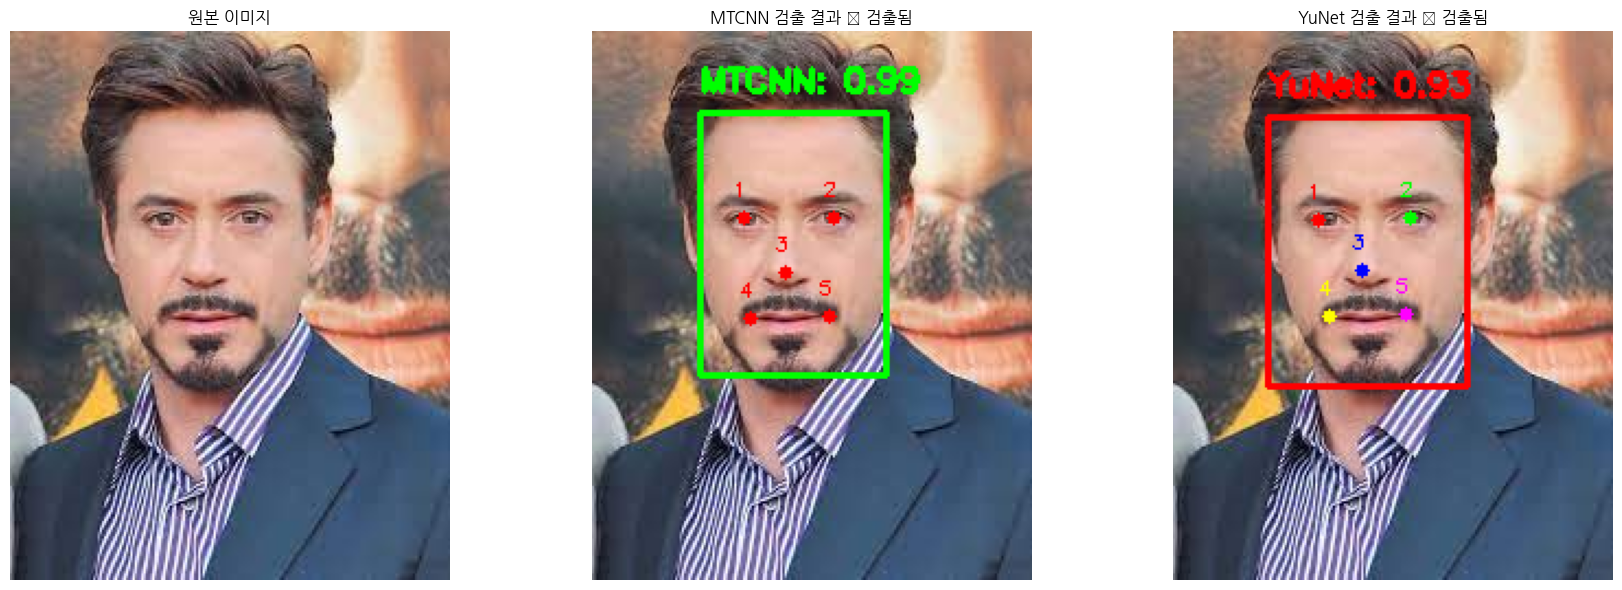


=== Í≤ÄÏ∂ú Í≤∞Í≥º ÏöîÏïΩ ===
MTCNN Í≤ÄÏ∂ú: ÏÑ±Í≥µ
YuNet Í≤ÄÏ∂ú: ÏÑ±Í≥µ

Î≤îÎ°Ä:
‚Ä¢ ÎÖπÏÉâ Î∞ïÏä§: MTCNN Î∞îÏö¥Îî© Î∞ïÏä§
‚Ä¢ ÌååÎûÄÏÉâ Î∞ïÏä§: YuNet Î∞îÏö¥Îî© Î∞ïÏä§
‚Ä¢ Ïà´Ïûê 1-5: ÎûúÎìúÎßàÌÅ¨ ÏàúÏÑú (1: Ïö∞Ï∏° Îàà, 2: Ï¢åÏ∏° Îàà, 3: ÏΩî, 4: Ïö∞Ï∏° ÏûÖÍº¨Î¶¨, 5: Ï¢åÏ∏° ÏûÖÍº¨Î¶¨)
‚Ä¢ Î∞ïÏä§ ÏúÑ Ïà´Ïûê: Confidence Score


In [12]:
# Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ ÎûúÎìúÎßàÌÅ¨ ÏãúÍ∞ÅÌôî ÎπÑÍµê Ìï®Ïàò
def visualize_detection_comparison(image_path):
    """
    MTCNNÍ≥º YuNetÏùò Í≤ÄÏ∂ú Í≤∞Í≥º(Î∞îÏö¥Îî© Î∞ïÏä§ + ÎûúÎìúÎßàÌÅ¨)Î•º ÎπÑÍµêÌïòÏó¨ ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.
    """
    global yunet_detector, yunet_available
    
    # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    original_img = Image.open(image_path).convert('RGB')
    original_np = np.array(original_img)
    
    # Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Ïù¥ÎØ∏ÏßÄÎì§
    mtcnn_result = original_np.copy()
    yunet_result = original_np.copy()
    
    # MTCNN Í≤ÄÏ∂ú Î∞è ÏãúÍ∞ÅÌôî
    try:
        # Í∏∞Ï°¥ MTCNN Î™®Îìà ÏÇ¨Ïö© (align_cpu.pyÏùò mtcnn_model ÌôúÏö©)
        from face_alignment.align_cpu import mtcnn_model
        
        # MTCNNÏúºÎ°ú Í≤ÄÏ∂ú (detect_faces Î©îÏÑúÎìú ÏÇ¨Ïö©)
        bboxes, landmarks = mtcnn_model.detect_faces(
            original_img, 
            min_face_size=20, 
            thresholds=[0.6, 0.7, 0.7], 
            nms_thresholds=[0.7, 0.7, 0.7], 
            factor=0.709
        )
        
        # MTCNN Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        if len(bboxes) > 0:
            for i, bbox in enumerate(bboxes):
                # Î∞îÏö¥Îî© Î∞ïÏä§ Í∑∏Î¶¨Í∏∞
                cv.rectangle(mtcnn_result, 
                           (int(bbox[0]), int(bbox[1])), 
                           (int(bbox[2]), int(bbox[3])), 
                           (0, 255, 0), 2)
                
                # ÎûúÎìúÎßàÌÅ¨ Í∑∏Î¶¨Í∏∞ (5Í∞ú Ï†ê)
                if len(landmarks) > i:
                    landmark = landmarks[i]
                    # landmarksÎäî [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5] ÌòïÌÉú
                    for j in range(5):
                        x, y = int(landmark[j]), int(landmark[j+5])
                        cv.circle(mtcnn_result, (x, y), 3, (255, 0, 0), -1)
                        cv.putText(mtcnn_result, str(j+1), (x-5, y-10), 
                                 cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                
                # confidence score ÌëúÏãú
                confidence = bbox[4] if len(bbox) > 4 else 0.0
                cv.putText(mtcnn_result, f'MTCNN: {confidence:.2f}', 
                         (int(bbox[0]), int(bbox[1]-10)), 
                         cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        mtcnn_detected = len(bboxes) > 0
        
    except Exception as e:
        print(f"MTCNN Í≤ÄÏ∂ú Ïò§Î•ò: {e}")
        import traceback
        traceback.print_exc()
        mtcnn_detected = False
        # Ïò§Î•ò Î©îÏãúÏßÄ ÌëúÏãú
        cv.putText(mtcnn_result, 'MTCNN Detection Failed', 
                 (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # YuNet Í≤ÄÏ∂ú Î∞è ÏãúÍ∞ÅÌôî
    yunet_detected = False
    if yunet_available and yunet_detector is not None:
        try:
            # Ïù¥ÎØ∏ÏßÄÎ•º OpenCV ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
            cv_img = cv.cvtColor(original_np, cv.COLOR_RGB2BGR)
            
            # YuNet Í≤ÄÏ∂ú
            yunet_detector.detector.setInputSize((cv_img.shape[1], cv_img.shape[0]))
            _, faces = yunet_detector.detector.detect(cv_img)
            
            if faces is not None and len(faces) > 0:
                for face in faces:
                    # Î∞îÏö¥Îî© Î∞ïÏä§ Ï¢åÌëú (x, y, w, h, confidence)
                    x, y, w, h = int(face[0]), int(face[1]), int(face[2]), int(face[3])
                    confidence = face[14] if len(face) > 14 else 0.0
                    
                    # Î∞îÏö¥Îî© Î∞ïÏä§ Í∑∏Î¶¨Í∏∞
                    cv.rectangle(yunet_result, (x, y), (x+w, y+h), (255, 0, 0), 2)
                    
                    # ÎûúÎìúÎßàÌÅ¨ Í∑∏Î¶¨Í∏∞ (Ïö∞Ï∏° Îàà, Ï¢åÏ∏° Îàà, ÏΩî, Ïö∞Ï∏° ÏûÖÍº¨Î¶¨, Ï¢åÏ∏° ÏûÖÍº¨Î¶¨)
                    landmarks_yunet = [
                        (int(face[4]), int(face[5])),   # Ïö∞Ï∏° Îàà
                        (int(face[6]), int(face[7])),   # Ï¢åÏ∏° Îàà  
                        (int(face[8]), int(face[9])),   # ÏΩî
                        (int(face[10]), int(face[11])), # Ïö∞Ï∏° ÏûÖÍº¨Î¶¨
                        (int(face[12]), int(face[13]))  # Ï¢åÏ∏° ÏûÖÍº¨Î¶¨
                    ]
                    
                    landmark_names = ['R_eye', 'L_eye', 'nose', 'R_mouth', 'L_mouth']
                    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
                    
                    for j, ((lx, ly), name, color) in enumerate(zip(landmarks_yunet, landmark_names, colors)):
                        cv.circle(yunet_result, (lx, ly), 3, color, -1)
                        cv.putText(yunet_result, str(j+1), (lx-5, ly-10), 
                                 cv.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
                    
                    # confidence score ÌëúÏãú
                    cv.putText(yunet_result, f'YuNet: {confidence:.2f}', 
                             (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                yunet_detected = True
            else:
                # Í≤ÄÏ∂ú Ïã§Ìå® Î©îÏãúÏßÄ
                cv.putText(yunet_result, 'YuNet: No Face Detected', 
                         (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        except Exception as e:
            print(f"YuNet Í≤ÄÏ∂ú Ïò§Î•ò: {e}")
            cv.putText(yunet_result, 'YuNet Detection Failed', 
                     (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    else:
        cv.putText(yunet_result, 'YuNet Not Available', 
                 (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, (128, 128, 128), 2)
    
    return mtcnn_result, yunet_result, mtcnn_detected, yunet_detected

# Ï≤´ Î≤àÏß∏ ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÎ°ú Î∞îÏö¥Îî© Î∞ïÏä§ Î∞è ÎûúÎìúÎßàÌÅ¨ ÎπÑÍµê
if test_images:
    test_image_path = test_images[0]
    print(f"Î∞îÏö¥Îî© Î∞ïÏä§ Î∞è ÎûúÎìúÎßàÌÅ¨ ÎπÑÍµê ÎåÄÏÉÅ: {os.path.basename(test_image_path)}")
    
    try:
        # Í≤ÄÏ∂ú Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        mtcnn_result, yunet_result, mtcnn_detected, yunet_detected = visualize_detection_comparison(test_image_path)
        
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎèÑ Î°úÎìú
        original_img = Image.open(test_image_path).convert('RGB')
        
        # ÏãúÍ∞ÅÌôî
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
        axes[0].imshow(original_img)
        axes[0].set_title('ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ')
        axes[0].axis('off')
        
        # MTCNN Í≤ÄÏ∂ú Í≤∞Í≥º
        axes[1].imshow(mtcnn_result)
        detection_status = "‚úÖ Í≤ÄÏ∂úÎê®" if mtcnn_detected else "‚ùå Í≤ÄÏ∂ú Ïã§Ìå®"
        axes[1].set_title(f'MTCNN Í≤ÄÏ∂ú Í≤∞Í≥º {detection_status}')
        axes[1].axis('off')
        
        # YuNet Í≤ÄÏ∂ú Í≤∞Í≥º
        axes[2].imshow(yunet_result)
        if yunet_available:
            detection_status = "‚úÖ Í≤ÄÏ∂úÎê®" if yunet_detected else "‚ùå Í≤ÄÏ∂ú Ïã§Ìå®"
            axes[2].set_title(f'YuNet Í≤ÄÏ∂ú Í≤∞Í≥º {detection_status}')
        else:
            axes[2].set_title('YuNet (ÏÇ¨Ïö© Î∂àÍ∞Ä)')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Í≤ÄÏ∂ú Í≤∞Í≥º ÏöîÏïΩ
        print("\n=== Í≤ÄÏ∂ú Í≤∞Í≥º ÏöîÏïΩ ===")
        print(f"MTCNN Í≤ÄÏ∂ú: {'ÏÑ±Í≥µ' if mtcnn_detected else 'Ïã§Ìå®'}")
        if yunet_available:
            print(f"YuNet Í≤ÄÏ∂ú: {'ÏÑ±Í≥µ' if yunet_detected else 'Ïã§Ìå®'}")
        else:
            print(f"YuNet Í≤ÄÏ∂ú: ÏÇ¨Ïö© Î∂àÍ∞Ä")
        
        print(f"\nÎ≤îÎ°Ä:")
        print(f"‚Ä¢ ÎÖπÏÉâ Î∞ïÏä§: MTCNN Î∞îÏö¥Îî© Î∞ïÏä§")
        print(f"‚Ä¢ ÌååÎûÄÏÉâ Î∞ïÏä§: YuNet Î∞îÏö¥Îî© Î∞ïÏä§")
        print(f"‚Ä¢ Ïà´Ïûê 1-5: ÎûúÎìúÎßàÌÅ¨ ÏàúÏÑú (1: Ïö∞Ï∏° Îàà, 2: Ï¢åÏ∏° Îàà, 3: ÏΩî, 4: Ïö∞Ï∏° ÏûÖÍº¨Î¶¨, 5: Ï¢åÏ∏° ÏûÖÍº¨Î¶¨)")
        print(f"‚Ä¢ Î∞ïÏä§ ÏúÑ Ïà´Ïûê: Confidence Score")
        
    except Exception as e:
        print(f"Î∞îÏö¥Îî© Î∞ïÏä§ ÏãúÍ∞ÅÌôî Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        import traceback
        traceback.print_exc()
else:
    print("ÎπÑÍµêÌï† ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏóÜÏäµÎãàÎã§.")

## 8. Í≤∞Î°† Î∞è Í∂åÏû•ÏÇ¨Ìï≠

In [13]:
print("=== EdgeFace ÌèâÍ∞ÄÎ•º ÏúÑÌïú MTCNN vs YuNet ÎπÑÍµê Í≤∞Î°† ===")
print()

if not yunet_available:
    print("‚ö†Ô∏è YuNetÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏóÜÏñ¥ ÎπÑÍµê Î∂ÑÏÑùÏù¥ Ï†úÌïúÎê©ÎãàÎã§.")
    print("MTCNNÎßå ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÏÉÅÌÉúÏûÖÎãàÎã§.")
    print()
    print("üí° Í∂åÏû•ÏÇ¨Ìï≠:")
    print("  ‚Ä¢ OpenCV 4.5.4 Ïù¥ÏÉÅÏù¥ ÏÑ§ÏπòÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏ÌïòÏÑ∏Ïöî")
    print("  ‚Ä¢ YuNet ONNX Î™®Îç∏ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî")
    print("  ‚Ä¢ ÌòÑÏû¨Îäî MTCNNÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ EdgeFace ÌèâÍ∞ÄÎ•º ÏßÑÌñâÌïòÏÑ∏Ïöî")
elif benchmark_results:
    avg_mtcnn_time = np.mean([r['mtcnn_time_ms'] for r in benchmark_results])
    avg_yunet_time = np.mean([r['yunet_time_ms'] for r in benchmark_results if r['yunet_time_ms'] > 0])
    avg_speedup = np.mean([r['speedup_ratio'] for r in benchmark_results if r['speedup_ratio'] > 0])
    avg_mtcnn_success = np.mean([r['mtcnn_success_rate'] for r in benchmark_results])
    avg_yunet_success = np.mean([r['yunet_success_rate'] for r in benchmark_results if r['yunet_success_rate'] > 0])
    
    print(f"üìä ÏÑ±Îä• ÏöîÏïΩ:")
    print(f"  ‚Ä¢ MTCNN ÌèâÍ∑† Ï∂îÎ°†ÏãúÍ∞Ñ: {avg_mtcnn_time:.1f}ms")
    if avg_yunet_time > 0:
        print(f"  ‚Ä¢ YuNet ÌèâÍ∑† Ï∂îÎ°†ÏãúÍ∞Ñ: {avg_yunet_time:.1f}ms")
        print(f"  ‚Ä¢ ÏÜçÎèÑ Ìñ•ÏÉÅ: {avg_speedup:.2f}Î∞∞")
    print(f"  ‚Ä¢ MTCNN ÏÑ±Í≥µÎ•†: {avg_mtcnn_success:.1%}")
    if avg_yunet_success > 0:
        print(f"  ‚Ä¢ YuNet ÏÑ±Í≥µÎ•†: {avg_yunet_success:.1%}")
    print()
    
    if avg_yunet_time > 0:
        print(f"üîç Î∂ÑÏÑù Í≤∞Í≥º:")
        if avg_speedup > 1:
            print(f"  ‚úÖ YuNetÏù¥ MTCNNÎ≥¥Îã§ {avg_speedup:.2f}Î∞∞ Îπ†Î¶Ñ")
        else:
            print(f"  ‚ö†Ô∏è  MTCNNÏù¥ YuNetÎ≥¥Îã§ {1/avg_speedup:.2f}Î∞∞ Îπ†Î¶Ñ")
        
        if avg_yunet_success >= avg_mtcnn_success:
            print(f"  ‚úÖ YuNet Í≤ÄÏ∂ú ÏÑ±Í≥µÎ•†Ïù¥ ÎèôÎì±ÌïòÍ±∞ÎÇò Îçî ÎÜíÏùå")
        else:
            print(f"  ‚ö†Ô∏è  MTCNN Í≤ÄÏ∂ú ÏÑ±Í≥µÎ•†Ïù¥ Îçî ÎÜíÏùå")
            
        print()
        print(f"üí° EdgeFace-XS(Œ≥=0.6) ÌèâÍ∞ÄÎ•º ÏúÑÌïú Í∂åÏû•ÏÇ¨Ìï≠:")
        
        if avg_speedup > 2 and avg_yunet_success >= 0.8:
            print(f"  ‚úÖ YuNet ÏÇ¨Ïö© Í∂åÏû• - ÏÜçÎèÑ Ïù¥Ï†êÏù¥ ÌÅ¨Í≥† ÏïàÏ†ïÏ†Å")
        elif avg_speedup > 1.5:
            print(f"  üìà YuNet ÏÇ¨Ïö© Í≥†Î†§ - ÏÜçÎèÑ Ïù¥Ï†ê ÏûàÏùå")
        else:
            print(f"  üîÑ MTCNN Ïú†ÏßÄ Í∂åÏû• - ÏÑ±Îä• Ï∞®Ïù¥Í∞Ä ÌÅ¨ÏßÄ ÏïäÏùå")
    else:
        print(f"üîç Î∂ÑÏÑù Í≤∞Í≥º:")
        print(f"  ‚Ä¢ YuNet ÎπÑÍµê Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå - MTCNNÎßå ÌÖåÏä§Ìä∏Îê®")
        print(f"üí° EdgeFace-XS(Œ≥=0.6) ÌèâÍ∞ÄÎ•º ÏúÑÌïú Í∂åÏû•ÏÇ¨Ìï≠:")
        print(f"  üîÑ ÌòÑÏû¨ MTCNN ÏÇ¨Ïö© Í∂åÏû•")
            
    print(f"  ‚Ä¢ CPU ÌôòÍ≤ΩÏóêÏÑúÏùò Ï∂îÎ°† ÏÜçÎèÑ ÏµúÏ†ÅÌôî ÌôïÏù∏")
    print(f"  ‚Ä¢ Face alignment ÏùºÍ¥ÄÏÑ± ÌôïÏù∏ ÌïÑÏöî")
    print(f"  ‚Ä¢ ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ÏÖã ÌèâÍ∞Ä Ïãú Ï≤òÎ¶¨Îüâ Ïù¥Ï†ê Í≥†Î†§")
    
else:
    print("Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ Í≤∞Î°†ÏùÑ ÎèÑÏ∂úÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
    print("ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÏôÄ Î™®Îç∏ ÏÑ§Ï†ïÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

print()
print("üìù Ï∂îÍ∞Ä Í≥†Î†§ÏÇ¨Ìï≠:")
if yunet_available:
    print("  ‚Ä¢ YuNetÏùÄ OpenCV DNN Î∞±ÏóîÎìúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Îã§ÏñëÌïú ÌîåÎû´ÌèºÏóêÏÑú ÏµúÏ†ÅÌôîÎê®")
    print("  ‚Ä¢ MTCNNÏùÄ PyTorch Í∏∞Î∞òÏúºÎ°ú GPU Í∞ÄÏÜç Ïãú Îçî ÌÅ∞ Ïù¥Ï†ê")
    print("  ‚Ä¢ Ïã§Ï†ú EdgeFace ÏÑ±Îä• ÌèâÍ∞Ä Ïãú ÎèôÏùºÌïú face alignment ÏÇ¨Ïö© Í∂åÏû•")
    print("  ‚Ä¢ Î∞∞Ïπò Ï≤òÎ¶¨ Ïãú YuNetÏùò Î©îÎ™®Î¶¨ Ìö®Ïú®ÏÑ± ÌôïÏù∏ ÌïÑÏöî")
else:
    print("  ‚Ä¢ YuNet ÏÑ§Ï†ï ÏôÑÎ£å ÌõÑ Îã§Ïãú ÎπÑÍµê Ïã§Ìñâ")
    print("  ‚Ä¢ MTCNN CPU Î≤ÑÏ†ÑÏúºÎ°ú ÌòÑÏû¨ EdgeFace ÌèâÍ∞Ä Í∞ÄÎä•")
    print("  ‚Ä¢ OpenCV Î≤ÑÏ†Ñ Î∞è YuNet Î™®Îç∏ ÌååÏùº ÌôïÏù∏ ÌïÑÏöî")

=== EdgeFace ÌèâÍ∞ÄÎ•º ÏúÑÌïú MTCNN vs YuNet ÎπÑÍµê Í≤∞Î°† ===

üìä ÏÑ±Îä• ÏöîÏïΩ:
  ‚Ä¢ MTCNN ÌèâÍ∑† Ï∂îÎ°†ÏãúÍ∞Ñ: 51.3ms
  ‚Ä¢ YuNet ÌèâÍ∑† Ï∂îÎ°†ÏãúÍ∞Ñ: 7.5ms
  ‚Ä¢ ÏÜçÎèÑ Ìñ•ÏÉÅ: 5.44Î∞∞
  ‚Ä¢ MTCNN ÏÑ±Í≥µÎ•†: 100.0%
  ‚Ä¢ YuNet ÏÑ±Í≥µÎ•†: 100.0%

üîç Î∂ÑÏÑù Í≤∞Í≥º:
  ‚úÖ YuNetÏù¥ MTCNNÎ≥¥Îã§ 5.44Î∞∞ Îπ†Î¶Ñ
  ‚úÖ YuNet Í≤ÄÏ∂ú ÏÑ±Í≥µÎ•†Ïù¥ ÎèôÎì±ÌïòÍ±∞ÎÇò Îçî ÎÜíÏùå

üí° EdgeFace-XS(Œ≥=0.6) ÌèâÍ∞ÄÎ•º ÏúÑÌïú Í∂åÏû•ÏÇ¨Ìï≠:
  ‚úÖ YuNet ÏÇ¨Ïö© Í∂åÏû• - ÏÜçÎèÑ Ïù¥Ï†êÏù¥ ÌÅ¨Í≥† ÏïàÏ†ïÏ†Å
  ‚Ä¢ CPU ÌôòÍ≤ΩÏóêÏÑúÏùò Ï∂îÎ°† ÏÜçÎèÑ ÏµúÏ†ÅÌôî ÌôïÏù∏
  ‚Ä¢ Face alignment ÏùºÍ¥ÄÏÑ± ÌôïÏù∏ ÌïÑÏöî
  ‚Ä¢ ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ÏÖã ÌèâÍ∞Ä Ïãú Ï≤òÎ¶¨Îüâ Ïù¥Ï†ê Í≥†Î†§

üìù Ï∂îÍ∞Ä Í≥†Î†§ÏÇ¨Ìï≠:
  ‚Ä¢ YuNetÏùÄ OpenCV DNN Î∞±ÏóîÎìúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Îã§ÏñëÌïú ÌîåÎû´ÌèºÏóêÏÑú ÏµúÏ†ÅÌôîÎê®
  ‚Ä¢ MTCNNÏùÄ PyTorch Í∏∞Î∞òÏúºÎ°ú GPU Í∞ÄÏÜç Ïãú Îçî ÌÅ∞ Ïù¥Ï†ê
  ‚Ä¢ Ïã§Ï†ú EdgeFace ÏÑ±Îä• ÌèâÍ∞Ä Ïãú ÎèôÏùºÌïú face alignment ÏÇ¨Ïö© Í∂åÏû•
  ‚Ä¢ Î∞∞Ïπò Ï≤òÎ¶¨ Ïãú YuNetÏùò Î©îÎ™®Î¶¨ Ìö®Ïú®ÏÑ± ÌôïÏù∏ ÌïÑÏöî


## 9. Í≤∞Í≥º Ï†ÄÏû•

In [14]:
# Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥ºÎ•º CSVÎ°ú Ï†ÄÏû•
if benchmark_results:
    df_results = pd.DataFrame(benchmark_results)
    
    # Í≤∞Í≥º Ï†ÄÏû•
    output_dir = Path('benchmark_results')
    output_dir.mkdir(exist_ok=True)
    
    # CSV Ï†ÄÏû•
    csv_path = output_dir / 'mtcnn_vs_yunet_benchmark.csv'
    df_results.to_csv(csv_path, index=False)
    print(f"Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥º Ï†ÄÏû•: {csv_path}")
    
    # ÏöîÏïΩ ÌÜµÍ≥Ñ Ï†ÄÏû•
    summary = {
        'avg_mtcnn_time_ms': df_results['mtcnn_time_ms'].mean(),
        'avg_yunet_time_ms': df_results['yunet_time_ms'].mean(),
        'avg_speedup_ratio': df_results['speedup_ratio'].mean(),
        'mtcnn_success_rate': df_results['mtcnn_success_rate'].mean(),
        'yunet_success_rate': df_results['yunet_success_rate'].mean(),
        'total_images_tested': len(df_results)
    }
    
    summary_path = output_dir / 'benchmark_summary.json'
    import json
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"ÏöîÏïΩ ÌÜµÍ≥Ñ Ï†ÄÏû•: {summary_path}")
    
    print("\nÎ™®Îì† Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
else:
    print("Ï†ÄÏû•Ìï† Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§.")

Î≤§ÏπòÎßàÌÅ¨ Í≤∞Í≥º Ï†ÄÏû•: benchmark_results/mtcnn_vs_yunet_benchmark.csv
ÏöîÏïΩ ÌÜµÍ≥Ñ Ï†ÄÏû•: benchmark_results/benchmark_summary.json

Î™®Îì† Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.
